In [1]:
!pip install opencv-python
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.colors as mcolors
from sklearn.cluster import KMeans
import json # library to handle JSON files
import requests # library to handle requests
import folium # map rendering library
import cv2, os
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from scipy import stats
import seaborn as sns; sns.set()
import math
import folium
from folium.features import DivIcon
mpl.use('Agg')
mpl.style.use('fivethirtyeight')
from sklearn.datasets import fetch_lfw_people, fetch_olivetti_faces
%matplotlib inline
from ipywidgets import interact

# JNB Lab Solution

## Section 1 Exercise

In [2]:
raw_CPS_data=  pd.read_json('https://data.cityofchicago.org/resource/kh4r-387c.json?$limit=100000')
raw_CPS_data.head(1) 

,school_id,legacy_unit_id,finance_id,short_name,long_name,primary_category,is_high_school,is_middle_school,is_elementary_school,is_pre_school,...,fifth_contact_title,fifth_contact_name,seventh_contact_title,seventh_contact_name,refugee_services,visual_impairments,freshman_start_end_time,sixth_contact_title,sixth_contact_name,hard_of_hearing
0,609966,3750,23531,HAMMOND,Charles G Hammond Elementary School,ES,False,True,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
raw_CPS_data.columns

Index(['school_id', 'legacy_unit_id', 'finance_id', 'short_name', 'long_name',
       'primary_category', 'is_high_school', 'is_middle_school',
       'is_elementary_school', 'is_pre_school', 'summary',
       'administrator_title', 'administrator', 'secondary_contact_title',
       'secondary_contact', 'address', 'city', 'state', 'zip', 'phone', 'fax',
       'cps_school_profile', 'website', 'facebook', 'attendance_boundaries',
       'grades_offered_all', 'grades_offered', 'student_count_total',
       'student_count_low_income', 'student_count_special_ed',
       'student_count_english_learners', 'student_count_black',
       'student_count_hispanic', 'student_count_white', 'student_count_asian',
       'student_count_native_american', 'student_count_other_ethnicity',
       'student_count_asian_pacific', 'student_count_multi',
       'student_count_hawaiian_pacific', 'student_count_ethnicity_not',
       'statistics_description', 'demographic_description', 'dress_code',
       'pre

In [4]:
raw_CPS_data['grades_offered'].value_counts()

PK,K-8       327
9-12         144
K-8           82
7-12          11
PK,K-6        10
PK,K-5        10
6-12           9
K-6            8
6-8            6
PK,K-4         4
K-12           4
PE,PK,K-8      4
11-12          4
5-8            3
PK             3
K-5            3
PK,K-3         3
8-12           2
PK,K-2         2
7-8            2
PK,3-8         1
9              1
K,4-8          1
K-1,5-8        1
3-12           1
K-3,5-8        1
1-8            1
PK,K-7         1
10-12          1
4-11           1
K-3            1
K-2            1
4-8            1
Name: grades_offered, dtype: int64

In [5]:
df=raw_CPS_data[['address','student_count_total','student_count_black','student_count_hispanic','student_count_white','zip']]
df23=df[df['zip']==60623]
df23=df23.reset_index(drop=True)
df23.columns= ["address","total","black","hispanic","white","zip"]
df23.head(1)

,address,total,black,hispanic,white,zip
0,2819 W 21ST PL,342,33,304,2,60623


In [6]:
for i in df23.index:
    df23.loc[i,'%black']=round(100*df23.loc[i,'black']/df23.loc[i,'total'],1)
    df23.loc[i,'%hispanic']=round(100*df23.loc[i,'hispanic']/df23.loc[i,'total'],1)
    df23.loc[i,'%white']=round(df23.loc[i,'white']/df23.loc[i,'total'],1)
df23.head(1)

,address,total,black,hispanic,white,zip,%black,%hispanic,%white
0,2819 W 21ST PL,342,33,304,2,60623,9.6,88.9,0.0


Intercept is  [98.71284906]
Slope is  [[-0.99515441]]
R^2 for OLS is  0.9996943205528053


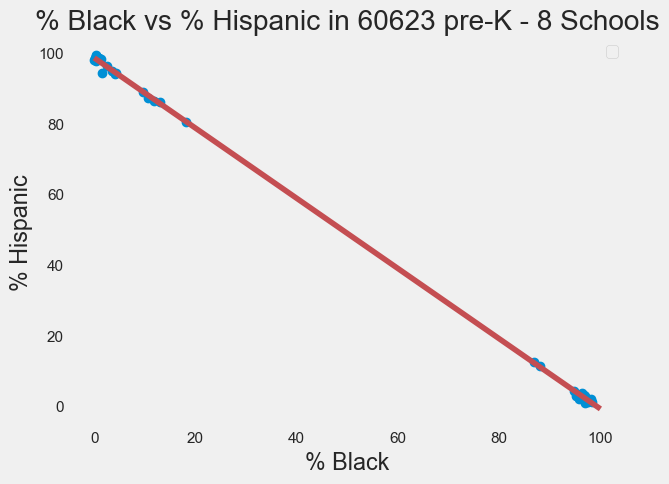

In [7]:
from sklearn.linear_model import LinearRegression #sklearn is a machine learning library
X=df23[["%black"]]
Y=df23[["%hispanic"]]
reg=LinearRegression()
reg.fit(X,Y)
print("Intercept is ", reg.intercept_)
print("Slope is ", reg.coef_)
print("R^2 for OLS is ", reg.score(X,Y))
# x values on the regression line will be between 0 and 100 with a spacing of .0
x = np.arange(0, 100 ,.01) 
# define the regression line y = mx+b here
[[m]]=reg.coef_
[b]=reg.intercept_
y =  m*x  + b   

fig=df23.plot(x='%black', y='%hispanic', style='o')  
plt.title('% Black vs % Hispanic in 60623 pre-K - 8 Schools')  
plt.xlabel('% Black')  
plt.ylabel('% Hispanic')  
# plot the regression line 
plt.plot(x,y, 'r') #add the color for red
plt.legend([],[], frameon=True)
plt.grid()
plt.show()

## Section 2 Exercise

In [8]:
# read from excel file, dropping all entries with N/A values
violence = pd.read_csv('Violence.csv').dropna(subset = ['LATITUDE', 'LONGITUDE'])

# Streamline columns to just latitude and longitude, reduce to just first 1000 entries
violence = violence[['LATITUDE', 'LONGITUDE']].head(1000)

# Reset the index for consistent numbering
violence = violence.reset_index(drop = True)

# Get the 100 colors used to identify clusters
colorlist = list(mcolors.XKCD_COLORS.values())[:100]

# Make a map that uses k-means clustering to divide locations into up to 100 clusters 
#the inout variable (clusters) specifies the number of clusters. 
#the input variable data specifies the locations.
def make_map(clusters,data):
    assert clusters >= 1, "Number of clusters must be at least 1"
    assert clusters <= len(colorlist), "Number of clusters exceeds maximum amount"
    x=data[['LATITUDE', 'LONGITUDE']]
    k_means = KMeans(n_clusters=clusters)
    k_means.fit(x)
    k_means_labels = k_means.labels_
    
    x['labels'] = k_means_labels
    k_map = folium.Map(location=[41.783, -87.621],  tiles="Stamen Toner", zoom_start=10)

    for i in np.arange(0,len(x),1):  #add parcel data one
        p=[x.loc[i,"LATITUDE"],x.loc[i,"LONGITUDE"]]# by one to the base map.
        k_map.add_child(folium.CircleMarker(p, radius=1,color=colorlist[x.loc[i, 'labels']], fill = True, fill_opacity = 1))
    return   k_map

Let's take a look at the 22 clusters.

In [9]:
cluster22_map = make_map(22,violence)
cluster22_map

C:\Users\pisihara\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\pisihara\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Here is an overlay of this map onto police districts.


 <img src="overlay.png" width="800px"> 

While it is not perfect, our k-means algorithm clustered the violent occurrences in a similar manner to the police district boundaries.

## Section 3 Exercise

In [10]:
def imagetovector(npix,directory,nimages):
    n=npix  #use nxn pixel image
    # You'll want to store all your images in a folder within the same directory as this notebook. 
    # Enter the name of that directory below.
    directory = directory # example: "images"

    # Dictionaries to store the image data and the dataframes we'll make from them.
    # The dataframes are used to translate data to and from excel.
    imgs = {}
    dfs = {}

    # Each image will be resized to ensure that their proportions are consistent with each other.
    # It's best to start with images that are already similarly sized so that images don't get
    # too distorted in the resize process. 
    # Adjust the size to your preference: (width, height)
    dsize = (n, n)

    # This will iterate over every image in the directory given, read it into data, and create a 
    # dataframe for it. Both the image data and its corresponding dataframe are stored.
    # Note that when being read into data, we interpret the image as grayscale. 
    pos = 0
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            imgs[pos] = cv2.imread(f, 0) # image data
            imgs[pos] = cv2.resize(imgs[pos], dsize)
            dfs[pos] = pd.DataFrame(imgs[pos]) # dataframe
            pos += 1

    # Exports the image dataframes to an excel file, with each excel sheet representing one image.
    # If there's already an excel file by the same name, it will overwrite it. Note that if the
    # excel file it's attempting to overwrite is already open, the write will be blocked.
    with pd.ExcelWriter('image_data.xlsx') as writer: 
        for i in np.arange(0, len(dfs)):
            dfs[i].to_excel(writer, sheet_name=str(i))
    def matrixtovector(matrix,n,s):
        t=0
        vec=pd.DataFrame()
        for i in np.arange(0,n,1):
            for j in np.arange(0,n,1):
                vec.loc[t,str(s)]=matrix.loc[i,j]
                t=t+1
        return vec

    numimages=nimages
    data=pd.DataFrame()
    for t in np.arange(0,numimages,1):
        data.loc[:,str(t)]=matrixtovector(dfs[t],n,t)            
    return data,imgs

In [11]:
[traindata,imgs]=imagetovector(64,"letters",8)
traindata.head(4)

,0,1,2,3,4,5,6,7
0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
1,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
2,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
3,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0


In [12]:
from sklearn.decomposition import PCA
letter=traindata
pca = PCA(n_components=2)
pca.fit(np.transpose(letter))
letter_pca = pca.transform(np.transpose(letter))
filtered = pca.inverse_transform(letter_pca)
print("original shape:   ", np.transpose(letter).shape)
print("transformed shape:", letter_pca.shape)

original shape:    (8, 4096)
transformed shape: (8, 2)


<b>Answer to part a)</b>

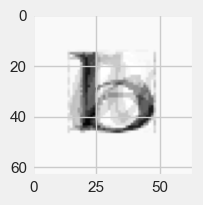

In [13]:
fig=plt.figure(figsize=(2,2))
plt.gca().imshow(filtered[4].reshape(64, 64),
                                 cmap="gray")

<b> Answer to part b)</b>

Image of First principal component vector

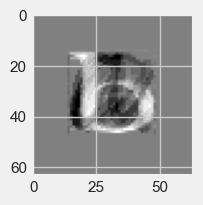

In [14]:
#image corresponding to the 1st basis vector.
fig=plt.figure(figsize=(2,2))
plt.gca().imshow(pca.components_[0].reshape(64, 64),
                                 cmap="gray")

Image of the second principal component vector.

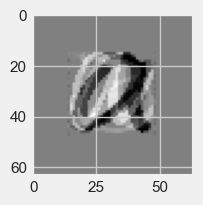

In [15]:
#image corresponding to the 2nd basis vector.
fig=plt.figure(figsize=(2,2))
plt.gca().imshow(pca.components_[1].reshape(64, 64),
                                 cmap="gray")

Answer to c).

In [16]:
letter_pca[1]

array([1286.48056884, 3118.77874561])

Answer to d) We could only model the first two pixels so would not have any idea of the images.

## Section 4 Exercise

In [17]:
def imagetovector(npix,directory,nimages):
    n=npix  #use nxn pixel image
    # You'll want to store all your images in a folder within the same directory as this notebook. 
    # Enter the name of that directory below.
    directory = directory # example: "images"

    # Dictionaries to store the image data and the dataframes we'll make from them.
    # The dataframes are used to translate data to and from excel.
    imgs = {}
    dfs = {}

    # Each image will be resized to ensure that their proportions are consistent with each other.
    # It's best to start with images that are already similarly sized so that images don't get
    # too distorted in the resize process. 
    # Adjust the size to your preference: (width, height)
    dsize = (n, n)

    # This will iterate over every image in the directory given, read it into data, and create a 
    # dataframe for it. Both the image data and its corresponding dataframe are stored.
    # Note that when being read into data, we interpret the image as grayscale. 
    pos = 0
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file
        if os.path.isfile(f):
            imgs[pos] = cv2.imread(f, 0) # image data
            imgs[pos] = cv2.resize(imgs[pos], dsize)
            dfs[pos] = pd.DataFrame(imgs[pos]) # dataframe
            pos += 1

    # Exports the image dataframes to an excel file, with each excel sheet representing one image.
    # If there's already an excel file by the same name, it will overwrite it. Note that if the
    # excel file it's attempting to overwrite is already open, the write will be blocked.
    with pd.ExcelWriter('image_data.xlsx') as writer: 
        for i in np.arange(0, len(dfs)):
            dfs[i].to_excel(writer, sheet_name=str(i))
    def matrixtovector(matrix,n,s):
        t=0
        vec=pd.DataFrame()
        for i in np.arange(0,n,1):
            for j in np.arange(0,n,1):
                vec.loc[t,str(s)]=matrix.loc[i,j]
                t=t+1
        return vec

    numimages=nimages
    data=pd.DataFrame()
    for t in np.arange(0,numimages,1):
        data.loc[:,str(t)]=matrixtovector(dfs[t],n,t)            
    return data,imgs 

In [18]:
[traindata,imgs]=imagetovector(32,"exerciseimages",8)
traindata.head(2)

,0,1,2,3,4,5,6,7
0,54.0,29.0,0.0,17.0,215.0,245.0,88.0,197.0
1,41.0,65.0,0.0,16.0,182.0,242.0,93.0,186.0


In [19]:
model = SVC(kernel='linear', C=1)
X=[traindata.loc[:,"0"],traindata.loc[:,"1"],traindata.loc[:,"2"],traindata.loc[:,"3"],traindata.loc[:,"4"],traindata.loc[:,"5"],traindata.loc[:,"6"],traindata.loc[:,"7"]]
Y=[0,0,0,0,1,1,1,1] #Labels the images 0=Hillary Clinton 1=Michelle Obama
model.fit(X,Y)
ypred=model.predict(X)
ypred

array([0, 0, 0, 0, 1, 1, 1, 1])

In [20]:
[testdata,testimgs]=imagetovector(32,"exercisetestimages",4)
testdata.tail(2)

,0,1,2,3
1022,80.0,69.0,36.0,42.0
1023,80.0,44.0,37.0,47.0


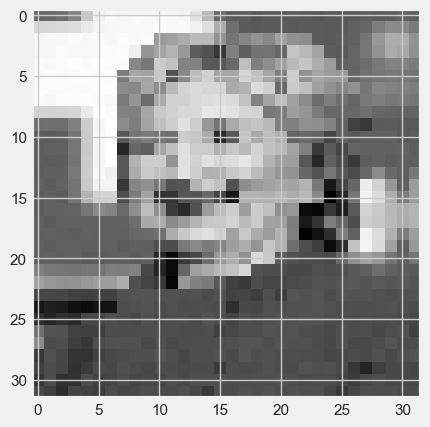

In [21]:
#display the first test image
plt.imshow(testimgs[0], cmap="gray") 

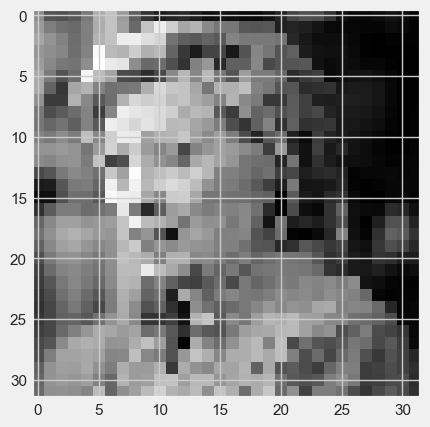

In [22]:
#display the second test image
plt.imshow(testimgs[1], cmap="gray") 

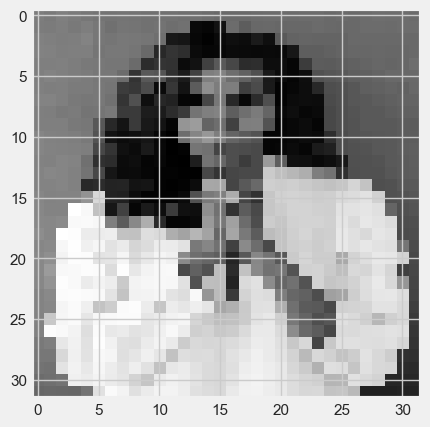

In [23]:
#display the third test image
plt.imshow(testimgs[2], cmap="gray") 

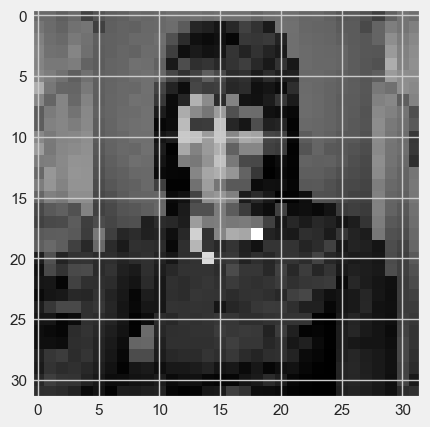

In [24]:
#display the fourth test image
plt.imshow(testimgs[3], cmap="gray") 

In [25]:
Xtest=[testdata.loc[:,"0"],testdata.loc[:,"1"],testdata.loc[:,"2"],testdata.loc[:,"3"]]
model.predict(Xtest)

array([1, 0, 0, 1])

Note that in the output prediction, 0=Hillary Clinton  and 1=Michelle Obama.